In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


# DOWNLOAD FILE LIBRARY

In [ ]:
!pip3 install vncorenlp
!pip install -q tf-models-official
!pip install -q emoji

In [ ]:
# !Download VnCoreNLP-1.1.1.jar & its word segmentation component (i.e. RDRSegmenter) 
# !mkdir -p vncorenlp/models/wordsegmenter
# !wget https://raw.githubusercontent.com/vncorenlp/VnCoreNLP/master/VnCoreNLP-1.1.1.jar
# !wget https://raw.githubusercontent.com/vncorenlp/VnCoreNLP/master/models/wordsegmenter/vi-vocab
# !wget https://raw.githubusercontent.com/vncorenlp/VnCoreNLP/master/models/wordsegmenter/wordsegmenter.rdr
# !mv VnCoreNLP-1.1.1.jar vncorenlp/ 
# !mv vi-vocab vncorenlp/models/wordsegmenter/
# !mv wordsegmenter.rdr vncorenlp/models/wordsegmenter/

# !mkdir -p pho2vec
# !wget https://public.vinai.io/word2vec_vi_words_300dims.zip
# !mv word2vec_vi_words_300dims.zip pho2vec/
# !unzip "./pho2vec/word2vec_vi_words_300dims.zip"

In [ ]:
# annotator = VnCoreNLP("vncorenlp/VnCoreNLP-1.1.1.jar", annotators="wseg", max_heap_size='-Xmx500m') 

# def preprocessing(row):
#   def tokenizer(row):
#     row = annotator.tokenize(row)
#     return ' '.join([' '.join(words) for words in row])
#   return tokenizer(row)

# IMPORT LIBRARY AND PATH DATASET

In [ ]:
import pandas as pd
import numpy as np
import os
from vncorenlp import VnCoreNLP
import numpy as np
import pickle
import matplotlib.pyplot as plt
import warnings
import logging

from gensim.test.utils import datapath, get_tmpfile
from gensim.models import KeyedVectors

import tensorflow as tf
# from transformers import TFAutoModel
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Dropout, Dense, Embedding, GRU, Bidirectional, LSTM
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.metrics import matthews_corrcoef, confusion_matrix
from sklearn import metrics
from sklearn.utils import shuffle
from official.nlp import optimization
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.train import CheckpointOptions
from tensorflow.keras.optimizers import Adam

np.random.seed(7)

In [ ]:
path_root = '/content/drive/MyDrive/KTDLTT'
path_img = os.path.join(path_root, 'model/VSMEC/BiGRU_pre/images')
MODEL_PATH = os.path.join(path_root, 'model/VSMEC/BiGRU_pre')
name_model = 'VSMEC_pre_BiGRU'

path_VSMEC_train = os.path.join(path_root, 'data/UIT-VSMEC/train_nor_811.xlsx')
path_VSMEC_test = os.path.join(path_root, 'data/UIT-VSMEC/test_nor_811.xlsx')
path_VSMEC_dev = os.path.join(path_root, 'data/UIT-VSMEC/valid_nor_811.xlsx')

# DATA LOADER AND PREPROCESSING

### Data loader

In [ ]:
df_train = pd.read_excel(path_VSMEC_train).iloc[:,1:]
df_test = pd.read_excel(path_VSMEC_test).iloc[:,1:]
df_dev = pd.read_excel(path_VSMEC_dev).iloc[:,1:]

In [ ]:
df_train.head(5)

,Emotion,Sentence
0,Other,cho mình xin bài nhạc tên là gì với ạ
1,Disgust,cho đáng đời con quỷ . về nhà lôi con nhà mày ...
2,Disgust,lo học đi . yêu đương lol gì hay lại thích học...
3,Enjoyment,uớc gì sau này về già vẫn có thể như cụ này :))
4,Enjoyment,mỗi lần có video của con là cứ coi đi coi lại ...


## Preprocessing Vietnamese texts

In [ ]:
# https://github.com/nguyenvanhieuvn/text-classification-tutorial/blob/master/text_classification_tutorial.ipynb
# https://nguyenvanhieu.vn/phan-loai-van-ban-tieng-viet
import regex as re
import emoji

### Standardize unicode 

In [ ]:
def convert_unicode(txt):
    char1252 = 'à|á|ả|ã|ạ|ầ|ấ|ẩ|ẫ|ậ|ằ|ắ|ẳ|ẵ|ặ|è|é|ẻ|ẽ|ẹ|ề|ế|ể|ễ|ệ|ì|í|ỉ|ĩ|ị|ò|ó|ỏ|õ|ọ|ồ|ố|ổ|ỗ|ộ|ờ|ớ|ở|ỡ|ợ|ù|ú|ủ|ũ|ụ|ừ|ứ|ử|ữ|ự|ỳ|ý|ỷ|ỹ|ỵ|À|Á|Ả|Ã|Ạ|Ầ|Ấ|Ẩ|Ẫ|Ậ|Ằ|Ắ|Ẳ|Ẵ|Ặ|È|É|Ẻ|Ẽ|Ẹ|Ề|Ế|Ể|Ễ|Ệ|Ì|Í|Ỉ|Ĩ|Ị|Ò|Ó|Ỏ|Õ|Ọ|Ồ|Ố|Ổ|Ỗ|Ộ|Ờ|Ớ|Ở|Ỡ|Ợ|Ù|Ú|Ủ|Ũ|Ụ|Ừ|Ứ|Ử|Ữ|Ự|Ỳ|Ý|Ỷ|Ỹ|Ỵ'
    charutf8 = 'à|á|ả|ã|ạ|ầ|ấ|ẩ|ẫ|ậ|ằ|ắ|ẳ|ẵ|ặ|è|é|ẻ|ẽ|ẹ|ề|ế|ể|ễ|ệ|ì|í|ỉ|ĩ|ị|ò|ó|ỏ|õ|ọ|ồ|ố|ổ|ỗ|ộ|ờ|ớ|ở|ỡ|ợ|ù|ú|ủ|ũ|ụ|ừ|ứ|ử|ữ|ự|ỳ|ý|ỷ|ỹ|ỵ|À|Á|Ả|Ã|Ạ|Ầ|Ấ|Ẩ|Ẫ|Ậ|Ằ|Ắ|Ẳ|Ẵ|Ặ|È|É|Ẻ|Ẽ|Ẹ|Ề|Ế|Ể|Ễ|Ệ|Ì|Í|Ỉ|Ĩ|Ị|Ò|Ó|Ỏ|Õ|Ọ|Ồ|Ố|Ổ|Ỗ|Ộ|Ờ|Ớ|Ở|Ỡ|Ợ|Ù|Ú|Ủ|Ũ|Ụ|Ừ|Ứ|Ử|Ữ|Ự|Ỳ|Ý|Ỷ|Ỹ|Ỵ'
    char1252 = char1252.split('|')
    charutf8 = charutf8.split('|')
    
    dic = {}
    for i in range(len(char1252)): dic[char1252[i]] = charutf8[i]
    return re.sub(
        r'à|á|ả|ã|ạ|ầ|ấ|ẩ|ẫ|ậ|ằ|ắ|ẳ|ẵ|ặ|è|é|ẻ|ẽ|ẹ|ề|ế|ể|ễ|ệ|ì|í|ỉ|ĩ|ị|ò|ó|ỏ|õ|ọ|ồ|ố|ổ|ỗ|ộ|ờ|ớ|ở|ỡ|ợ|ù|ú|ủ|ũ|ụ|ừ|ứ|ử|ữ|ự|ỳ|ý|ỷ|ỹ|ỵ|À|Á|Ả|Ã|Ạ|Ầ|Ấ|Ẩ|Ẫ|Ậ|Ằ|Ắ|Ẳ|Ẵ|Ặ|È|É|Ẻ|Ẽ|Ẹ|Ề|Ế|Ể|Ễ|Ệ|Ì|Í|Ỉ|Ĩ|Ị|Ò|Ó|Ỏ|Õ|Ọ|Ồ|Ố|Ổ|Ỗ|Ộ|Ờ|Ớ|Ở|Ỡ|Ợ|Ù|Ú|Ủ|Ũ|Ụ|Ừ|Ứ|Ử|Ữ|Ự|Ỳ|Ý|Ỷ|Ỹ|Ỵ',
        lambda x: dic[x.group()], txt
    )

### Standardize accent typing

In [ ]:
vowels_to_ids = {}
vowels_table = [
    ['a', 'à', 'á', 'ả', 'ã', 'ạ', 'a' ],
    ['ă', 'ằ', 'ắ', 'ẳ', 'ẵ', 'ặ', 'aw'],
    ['â', 'ầ', 'ấ', 'ẩ', 'ẫ', 'ậ', 'aa'],
    ['e', 'è', 'é', 'ẻ', 'ẽ', 'ẹ', 'e' ],
    ['ê', 'ề', 'ế', 'ể', 'ễ', 'ệ', 'ee'],
    ['i', 'ì', 'í', 'ỉ', 'ĩ', 'ị', 'i' ],
    ['o', 'ò', 'ó', 'ỏ', 'õ', 'ọ', 'o' ],
    ['ô', 'ồ', 'ố', 'ổ', 'ỗ', 'ộ', 'oo'],
    ['ơ', 'ờ', 'ớ', 'ở', 'ỡ', 'ợ', 'ow'],
    ['u', 'ù', 'ú', 'ủ', 'ũ', 'ụ', 'u' ],
    ['ư', 'ừ', 'ứ', 'ử', 'ữ', 'ự', 'uw'],
    ['y', 'ỳ', 'ý', 'ỷ', 'ỹ', 'ỵ', 'y' ]
]
for i in range(len(vowels_table)):
    for j in range(len(vowels_table[i]) - 1):
        vowels_to_ids[vowels_table[i][j]] = (i, j)

In [ ]:
def is_valid_vietnamese_word(word):
    chars = list(word)
    vowel_indexes = -1
    for index, char in enumerate(chars):
        x, y = vowels_to_ids.get(char, (-1, -1))
        if x != -1:
            if vowel_indexes == -1: vowel_indexes = index
            else:
                if index - vowel_indexes != 1: return False
                vowel_indexes = index
    return True

In [ ]:
def standardize_word_typing(word):
    if not is_valid_vietnamese_word(word): return word
    chars = list(word)
    dau_cau = 0
    vowel_indexes = []
    qu_or_gi = False

    for index, char in enumerate(chars):
        x, y = vowels_to_ids.get(char, (-1, -1))
        if x == -1: continue
        elif x == 9:  # check qu
            if index != 0 and chars[index - 1] == 'q':
                chars[index] = 'u'
                qu_or_gi = True
        elif x == 5:  # check gi
            if index != 0 and chars[index - 1] == 'g':
                chars[index] = 'i'
                qu_or_gi = True

        if y != 0:
            dau_cau = y
            chars[index] = vowels_table[x][0]

        if not qu_or_gi or index != 1:
            vowel_indexes.append(index)

    if len(vowel_indexes) < 2:
        if qu_or_gi:
            if len(chars) == 2:
                x, y = vowels_to_ids.get(chars[1])
                chars[1] = vowels_table[x][dau_cau]
            else:
                x, y = vowels_to_ids.get(chars[2], (-1, -1))
                if x != -1: chars[2] = vowels_table[x][dau_cau]
                else: chars[1] = vowels_table[5][dau_cau] if chars[1] == 'i' else vowels_table[9][dau_cau]
            return ''.join(chars)
        return word

    for index in vowel_indexes:
        x, y = vowels_to_ids[chars[index]]
        if x == 4 or x == 8:  # ê, ơ
            chars[index] = vowels_table[x][dau_cau]
            return ''.join(chars)

    if len(vowel_indexes) == 2:
        if vowel_indexes[-1] == len(chars) - 1:
            x, y = vowels_to_ids[chars[vowel_indexes[0]]]
            chars[vowel_indexes[0]] = vowels_table[x][dau_cau]
        else:
            x, y = vowels_to_ids[chars[vowel_indexes[1]]]
            chars[vowel_indexes[1]] = vowels_table[x][dau_cau]
    else:
        x, y = vowels_to_ids[chars[vowel_indexes[1]]]
        chars[vowel_indexes[1]] = vowels_table[x][dau_cau]
    return ''.join(chars)

In [ ]:
def standardize_sentence_typing(sentence):
    sentence = sentence.lower()
    words = sentence.split()
    for index, word in enumerate(words):
        cw = re.sub(r'(^\p{P}*)([p{L}.]*\p{L}+)(\p{P}*$)', r'\1/\2/\3', word).split('/')
        if len(cw) == 3: cw[1] = standardize_word_typing(cw[1])
        words[index] = ''.join(cw)
    return ' '.join(words)

### Normalize acronyms

In [ ]:
!wget https://gist.githubusercontent.com/nguyenvanhieuvn/7d9441c10b3c2739499fc5a4d9ea06fb/raw/df939245b3e841b62af115be4dcb3516dadc9fc5/teencode.txt
replace_list = {
    'ô kêi': 'ok', 'okie': 'ok', 'o kê': 'ok', 'okey': 'ok', 'ôkê': 'ok', 'oki': 'ok', 'oke': 'ok', 'okay': 'ok', 'okê': 'ok',
    'tks': 'cảm ơn', 'thks': 'cảm ơn', 'thanks': 'cảm ơn', 'ths': 'cảm ơn', 'thank': 'cảm ơn',
    'kg': 'không', 'not': 'không', 'k': 'không', 'kh': 'không', 'kô': 'không', 'hok': 'không', 'ko': 'không', 'khong': 'không', 'kp': 'không phải',
    'he he': 'tích cực', 'hehe': 'tích cực', 'hihi': 'tích cực', 'haha': 'tích cực', 'hjhj': 'tích cực', 'thick': 'tích cực',
    'lol': 'tiêu cực', 'cc': 'tiêu cực', 'huhu': 'tiêu cực', 'cute': 'dễ thương',
     
    'sz': 'cỡ', 'size': 'cỡ', 
    'wa': 'quá', 'wá': 'quá', 'qá': 'quá', 
    'đx': 'được', 'dk': 'được', 'dc': 'được', 'đk': 'được', 'đc': 'được', 
    'vs': 'với', 'j': 'gì', '“': ' ', 'time': 'thời gian', 'm': 'mình', 'mik': 'mình', 'r': 'rồi', 'bjo': 'bao giờ', 'very': 'rất',

    'authentic': 'chuẩn chính hãng', 'aut': 'chuẩn chính hãng', 'auth': 'chuẩn chính hãng', 'date': 'hạn sử dụng', 'hsd': 'hạn sử dụng', 
    'store': 'cửa hàng', 'sop': 'cửa hàng', 'shopE': 'cửa hàng', 'shop': 'cửa hàng', 
    'sp': 'sản phẩm', 'product': 'sản phẩm', 'hàg': 'hàng', 
    'ship': 'giao hàng', 'delivery': 'giao hàng', 'síp': 'giao hàng', 'order': 'đặt hàng',

    'gud': 'tốt', 'wel done': 'tốt', 'good': 'tốt', 'gút': 'tốt', 'tot': 'tốt', 'nice': 'tốt', 'perfect': 'rất tốt', 
    'quality': 'chất lượng', 'chất lg': 'chất lượng', 'chat': 'chất', 'excelent': 'hoàn hảo', 'bt': 'bình thường',
    'sad': 'tệ', 'por': 'tệ', 'poor': 'tệ', 'bad': 'tệ', 
    'beautiful': 'đẹp tuyệt vời', 'dep': 'đẹp', 
    'xau': 'xấu', 'sấu': 'xấu', 
     
    'thik': 'thích', 'iu': 'yêu', 'fake': 'giả mạo', 
    'quickly': 'nhanh', 'quick': 'nhanh', 'fast': 'nhanh',
    'fresh': 'tươi', 'delicious': 'ngon',

    'dt': 'điện thoại', 'fb': 'facebook', 'face': 'facebook', 'ks': 'khách sạn', 'nv': 'nhân viên',
    'nt': 'nhắn tin', 'ib': 'nhắn tin', 'tl': 'trả lời', 'trl': 'trả lời', 'rep': 'trả lời',
    'fback': 'feedback', 'fedback': 'feedback',
    'sd': 'sử dụng', 'sài': 'xài', 

    '^_^': 'tích cực', ':)': 'tích cực', ':(': 'tiêu cực',
    '❤️': 'tích cực', '👍': 'tích cực', '🎉': 'tích cực', '😀': 'tích cực', '😍': 'tích cực', '😂': 'tích cực', '🤗': 'tích cực', '😙': 'tích cực', '🙂': 'tích cực', 
    '😔': 'tiêu cực', '😓': 'tiêu cực', 
    '⭐': 'star', '*': 'star', '🌟': 'star',
}
with open('teencode.txt', encoding='utf-8') as f:
    for pair in f.readlines():
        key, value = pair.split('\t')
        replace_list[key] = value.strip()

--2021-06-24 11:15:19--  https://gist.githubusercontent.com/nguyenvanhieuvn/7d9441c10b3c2739499fc5a4d9ea06fb/raw/df939245b3e841b62af115be4dcb3516dadc9fc5/teencode.txt
Resolving gist.githubusercontent.com (gist.githubusercontent.com)... 185.199.110.133, 185.199.108.133, 185.199.109.133, ...
Connecting to gist.githubusercontent.com (gist.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5656 (5.5K) [text/plain]
Saving to: ‘teencode.txt.3’

teencode.txt.3      100%[===================>]   5.52K  --.-KB/s    in 0s      

2021-06-24 11:15:20 (66.4 MB/s) - ‘teencode.txt.3’ saved [5656/5656]



In [ ]:
import string
def normalize_acronyms(text):
    words = []
    for word in text.strip().split():
        # word = word.strip(string.punctuation)
        if word not in replace_list.keys(): words.append(word)
        else: words.append(replace_list[word])
    return ' '.join(words)

### Word segmentation

In [ ]:
annotator = VnCoreNLP(os.path.join(path_root, "src/vncorenlp/VnCoreNLP-1.1.1.jar"), annotators="wseg", max_heap_size='-Xmx500m') 

def word_segmentation(row):
  row = annotator.tokenize(row)
  row = ' '.join([' '.join(words) for words in row])
  return row

### Combine all

In [ ]:
def text_preprocess(text):
    text = re.sub(r'<[^>]*>', '', text) # Remove HTML code
    text = convert_unicode(text) 
    text = standardize_sentence_typing(text)
    text = normalize_acronyms(text)
    text = word_segmentation(text) 
    text = re.sub(
        r'[^\s\wáàảãạăắằẳẵặâấầẩẫậéèẻẽẹêếềểễệóòỏõọôốồổỗộơớờởỡợíìỉĩịúùủũụưứừửữựýỳỷỹỵđ_]',
        ' ', # Remove unnecessary characters
        text
    )
    text = re.sub(r'\s+', ' ', text).strip() # Remove extra whitespace
    text = emoji.demojize(text) # Remove Emojis
    return text

In [ ]:
df_train.loc[:, 'Sentence'] = df_train.loc[:, 'Sentence'].apply(text_preprocess)
df_test.loc[:, 'Sentence'] = df_test.loc[:, 'Sentence'].apply(text_preprocess)
df_dev.loc[:, 'Sentence'] = df_dev.loc[:, 'Sentence'].apply(text_preprocess)

In [ ]:
df_train.head(5)

,Emotion,Sentence
0,Other,cho mình xin bài nhạc tên là gì với ạ
1,Disgust,cho đáng_đời con quỷ về nhà lôi con nhà mày ra...
2,Disgust,lo học đi yêu_đương lồn gì hay lại thích học_s...
3,Enjoyment,uớc gì sau_này về già vẫn có_thể như cụ này
4,Enjoyment,mỗi lần có video của con là cứ coi đi coi lại ...


## Embedding word using PhoW2V

In [ ]:
# Load Pho2wv
# pho2wv = KeyedVectors.load_word2vec_format(os.path.join(path_root, 'src/word2vec_vi_words_300dims.txt'))

In [ ]:
MAX_NB_WORDS = 75000
MAX_SEQUENCE_LENGTH = 128
DROPOUT = 0.5
nclasses = len(df_train['Emotion'].unique())
EMBEDDING_DIM = 300
BATCH_SIZE = 50
EPOCH = 10
lr = 1e-2
STEPS_PER_EPOCH = len(df_train['Sentence']) // BATCH_SIZE
VALIDATION_STEPS = len(df_dev['Sentence']) // BATCH_SIZE

In [ ]:
tokenizer = Tokenizer(num_words=MAX_NB_WORDS, oov_token='<OOV>')
tokenizer.fit_on_texts(df_train['Sentence'])
word_index = tokenizer.word_index

In [ ]:
def prepare_input(sents, tokenizer, MAX_SEQUENCE_LENGTH=MAX_SEQUENCE_LENGTH):
  sequences = tokenizer.texts_to_sequences(sents)
  sents = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH, truncating='post', padding='post')
  return sents

In [ ]:
labels = {emo:id_  for id_, emo in enumerate(list(df_train['Emotion'].unique()))}
def label_encoder(row):
  row = labels[row]
  return row

In [ ]:
X_train = prepare_input(df_train['Sentence'], tokenizer)
Y_train = np.array(df_train['Emotion'].apply(label_encoder).tolist())

X_dev = prepare_input(df_dev['Sentence'], tokenizer)
Y_dev = np.array(df_dev['Emotion'].apply(label_encoder).tolist())

In [ ]:
# # Create embedding matrix 
# def create_embedding(EMBEDDING_DIM, word_index, embedding_dict):
#   embedding_matrix = np.random.random((len(word_index) + 1, EMBEDDING_DIM))
#   for word, i in word_index.items():
#     try:
#       embedding_vector = embedding_dict.get_vector(word)
#     except:
#       embedding_vector = None
#     if embedding_vector is not None:
#       if len(embedding_matrix[i]) != len(embedding_vector):
#         # words not found in embedding index will be all-zeros.
#           if len(embedding_matrix[i]) != len(embedding_vector):
#             print("could not broadcast input array from shape", str(len(embedding_matrix[i])),
#                   "into shape", str(len(embedding_vector)), " Please make sure your"
#                                                             " EMBEDDING_DIM is equal to embedding_vector file ,GloVe,")
#             exit(1)
#           embedding_matrix[i] = embedding_vector
#   return embedding_matrix
# embedding_matrix = create_embedding(EMBEDDING_DIM, word_index, embedding_dict=pho2wv)
# np.save(os.path.join(path_root, 'data/vector/pho2wv_pre_VSMEC.npy'), embedding_matrix)

In [ ]:
# Load embedding matrix from file npy
embedding_matrix = np.load(os.path.join(path_root, 'data/vector/pho2wv_pre_VSMEC.npy'))

# Fine-tuning with TensorFlow

## Define the model

In [ ]:
def create_model(word_index, embedding_matrix, optimizer, nclasses=nclasses, MAX_SEQUENCE_LENGTH=MAX_SEQUENCE_LENGTH, EMBEDDING_DIM=EMBEDDING_DIM, dropout=DROPOUT, gru_node=32):
  model = Sequential()
  
  model.add(Embedding(len(word_index) + 1,
                      EMBEDDING_DIM,
                      weights=[embedding_matrix],
                      input_length=MAX_SEQUENCE_LENGTH,
                      trainable=True))
  
  model.add(Bidirectional(GRU(gru_node, return_sequences=True)))
  model.add(Bidirectional(GRU(gru_node)))
  model.add(Dropout(dropout))
  
  model.add(Dense(nclasses, activation='softmax'))

  model.compile(loss='sparse_categorical_crossentropy',
                      optimizer=optimizer,
                      metrics=['accuracy'])
  return model

## Optimizers

In [ ]:
optimizer = 'adam'

## Callbacks

In [ ]:
early_stop_callback = EarlyStopping(monitor='val_loss', patience=5, verbose=1)

checkpoint_path = MODEL_PATH + '/checkpoints/cp-{epoch:03d}.ckpt'
checkpoint_dir = os.path.dirname(checkpoint_path)

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath = checkpoint_path, 
    save_weights_only = True,
    save_best_only=True,
    mode='min',
    verbose = 1
)

## Training

In [ ]:
# optimizer = 'adam'
model = create_model(word_index, embedding_matrix, optimizer, nclasses, MAX_SEQUENCE_LENGTH, EMBEDDING_DIM, DROPOUT, 128)
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 128, 300)          1215900   
_________________________________________________________________
bidirectional_2 (Bidirection (None, 128, 256)          330240    
_________________________________________________________________
bidirectional_3 (Bidirection (None, 256)               296448    
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 7)                 1799      
Total params: 1,844,387
Trainable params: 1,844,387
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history = model.fit(X_train, Y_train,
                              validation_data=(X_dev, Y_dev),
                              epochs=EPOCH,
                              batch_size=BATCH_SIZE,
                              callbacks = [
                                  early_stop_callback, 
                                  checkpoint_callback
                              ],
                              verbose=1)

Epoch 1/10
111/111 [==============================] - 26s 179ms/step - loss: 1.8779 - accuracy: 0.2525 - val_loss: 1.7387 - val_accuracy: 0.2332

Epoch 00001: val_loss improved from inf to 1.73872, saving model to /content/drive/MyDrive/KTDLTT/model/VSMEC/BiGRU_pre/checkpoints/cp-001.ckpt
Epoch 2/10
111/111 [==============================] - 19s 168ms/step - loss: 1.7232 - accuracy: 0.3194 - val_loss: 1.7475 - val_accuracy: 0.3397

Epoch 00002: val_loss did not improve from 1.73872
Epoch 3/10
111/111 [==============================] - 19s 168ms/step - loss: 1.5182 - accuracy: 0.4117 - val_loss: 1.4841 - val_accuracy: 0.4300

Epoch 00003: val_loss improved from 1.73872 to 1.48410, saving model to /content/drive/MyDrive/KTDLTT/model/VSMEC/BiGRU_pre/checkpoints/cp-003.ckpt
Epoch 4/10
111/111 [==============================] - 19s 168ms/step - loss: 1.2558 - accuracy: 0.5296 - val_loss: 1.3955 - val_accuracy: 0.4854

Epoch 00004: val_loss improved from 1.48410 to 1.39548, saving model to /

# Predict on test data

In [ ]:
X_test = prepare_input(df_test['Sentence'], tokenizer)
y_test = np.array(df_test['Emotion'].apply(label_encoder).tolist())

In [ ]:
print("\n Evaluating Model ... \n")
y_pred = model.predict(X_test, batch_size=BATCH_SIZE, verbose=1).argmax(axis=-1)
metric = metrics.classification_report(y_test, y_pred, output_dict=True)
print(metrics.classification_report(y_test, y_pred, target_names=labels, digits=4))


 Evaluating Model ... 

14/14 [==============================] - 2s 53ms/step
              precision    recall  f1-score   support

       Other     0.4507    0.4961    0.4723       129
     Disgust     0.4649    0.6515    0.5426       132
   Enjoyment     0.5667    0.6166    0.5906       193
       Anger     0.4615    0.1500    0.2264        40
    Surprise     0.6000    0.3243    0.4211        37
     Sadness     0.6582    0.4483    0.5333       116
        Fear     0.7045    0.6739    0.6889        46

    accuracy                         0.5339       693
   macro avg     0.5581    0.4801    0.4965       693
weighted avg     0.5459    0.5339    0.5263       693



In [ ]:
f1 = round(metric['macro avg']['f1-score'], 4)
name_model_ = name_model + str(f1).replace('.', '') + '_' + str(lr).replace('.', '') + '_' + str(MAX_SEQUENCE_LENGTH) + '_' + str(BATCH_SIZE) + '_' + str(DROPOUT).replace('.', '') + '_' + '.h5'
name_img_ = 'loss' + str(f1).replace('.', '') + '_' + str(lr).replace('.', '') + '_' + str(MAX_SEQUENCE_LENGTH) + '_' + str(BATCH_SIZE) + '_' + str(DROPOUT).replace('.', '') + '_' + str(f1).replace('.', '') + '.png'
model.save_weights(os.path.join(MODEL_PATH, name_model_))

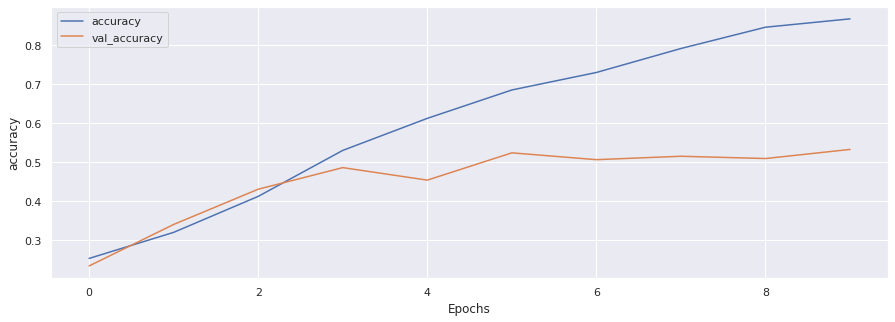

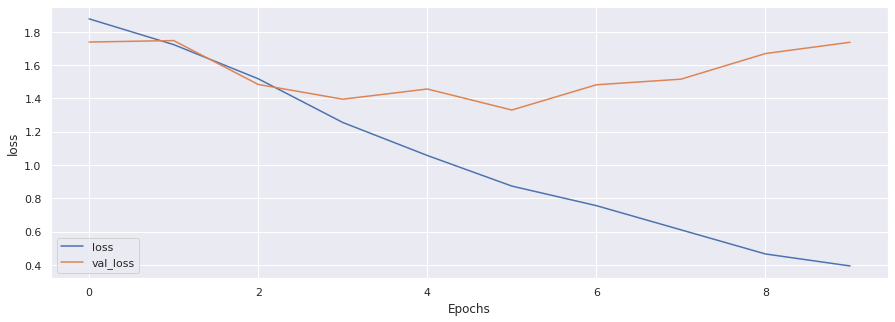

In [ ]:
def plot_graphs(history, string):
  fig = plt.figure(figsize=(15, 5))
  name_img = string + '_' + str(lr).replace('.', '') + '_' + str(MAX_SEQUENCE_LENGTH) + '_' + str(BATCH_SIZE) + '_' + str(DROPOUT).replace('.', '') + '_' + str(f1).replace('.', '') + '.png'
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string], '')
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  fig.savefig(os.path.join(path_img, name_img), bbox_inches='tight') 
  plt.show()

plot_graphs(history, 'accuracy')
plot_graphs(history, 'loss')

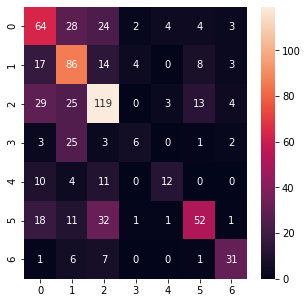

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

def _confusion_matrix(Y_test, y_pred, metric, name_model, path_img=path_img):
  f1 = round(metric['macro avg']['f1-score'], 4)
  name_img = 'CM_' + name_model + '_' + str(f1).replace('.', '') + '.png' 
  cf_matrix = confusion_matrix(Y_test, y_pred)
  fig = plt.figure(figsize=(5, 5))
  sns.heatmap(cf_matrix, annot=True, fmt='g')
  sns.set(font_scale=1)
  fig.savefig(os.path.join(path_img, name_img), bbox_inches='tight')
  plt.show()

_confusion_matrix(y_test, y_pred, metric, name_model)

### Load weight

In [ ]:
# X_test = prepare_input(df_test['Comment'], tokenizer)

In [ ]:
# df_dev.head(2)

In [ ]:
# # Load model predict
# from tensorflow.train import latest_checkpoint
# name_model = 'ViCTSD_toxic_pre_BiGRU06444_0001_128_50_05_.h5'
# reloaded_model = create_model(word_index, embedding_matrix, optimizer, nclasses=nclasses, MAX_SEQUENCE_LENGTH=128, EMBEDDING_DIM=EMBEDDING_DIM, dropout=DROPOUT, hidden_layer=3, GRU_node=32)
# reloaded_model.load_weights(os.path.join(MODEL_PATH, name_model))
# reloaded_model.summary()

In [ ]:
# print("\n Evaluating Model ... \n")
# y_pred = reloaded_model.predict(X_test, batch_size=BATCH_SIZE, verbose=1).argmax(axis=-1)
# # metric = metrics.classification_report(y_test, y_pred, output_dict=True)
# # print(metrics.classification_report(y_test, y_pred))#, digits=4, target_names=['negative', 'neutral', 'positive']))